In [493]:
#WARNING SUPPRESSION
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys

import matplotlib as plt
from pathlib import Path
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from scipy.interpolate import make_interp_spline, BSpline, RectBivariateSpline
from scipy.signal import find_peaks

import matplotlib as mpl

In [494]:
def generate_input_signal(freq, duration, num_samples):
    t = np.linspace(0, duration, num_samples)
    v_in = np.cos(2 * np.pi * freq * t)
    return t, v_in

def apply_nonlinearity(v_in, a0=0.0, a1=1.0, a2=0.0, a3=0.0):
    """Apply a polynomial non-linearity up to third order"""
    return a0 + a1 * v_in**1 + a2 * v_in**2 + a3 * v_in**3 

def compute_fft(signal, fs):
    """Compute single-sided FFT and frequency axis"""
    n = len(signal)
    f = np.fft.rfftfreq(n, d=1/fs)
    fft_mag = (np.abs(np.fft.rfft(signal)) / n)
    return f, fft_mag


def detect_and_annotate_harmonics(f, fft_mag, f0, threshold=0.01):
    peaks, _ = find_peaks(fft_mag, height=threshold)
    harmonic_indices = []
    
    for i in range(2, 10):
        target_freq = i * f0
        idx = np.argmin(np.abs(f - target_freq))
        if idx in peaks:
            harmonic_indices.append(idx)

    return(harmonic_indices)


In [495]:




# === Parameters ===
num_samples = 10000
freq = 1e6         
duration = 100e-6   
fs = num_samples / duration  # sampling frequency

# === Simulation ===


# Set non-linearity coefficients
a0 = 0.2    # DC offset
a1 = 0.6    # Slight gain reduction
a2 = -0.2   # Small asymmetry (clamp behavior)
a3 = 0.4   # Mild compression (saturation)

sig_distortion = apply_nonlinearity(np.linspace(-1,1,100), a0, a1, a2, a3)

t, v_in = generate_input_signal(freq, duration, num_samples)
v_out = apply_nonlinearity(v_in, a0, a1, a2, a3)

p_out = detect_and_annotate_harmonics(f, f_out, freq, threshold=0.01)

f, f_out = compute_fft(v_out, fs)
f, f_in = compute_fft(v_in, fs)

print(p_out)

[]


/tmp/ipykernel_1632422/1358882544.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-6, 0)


<Figure size 640x480 with 0 Axes>

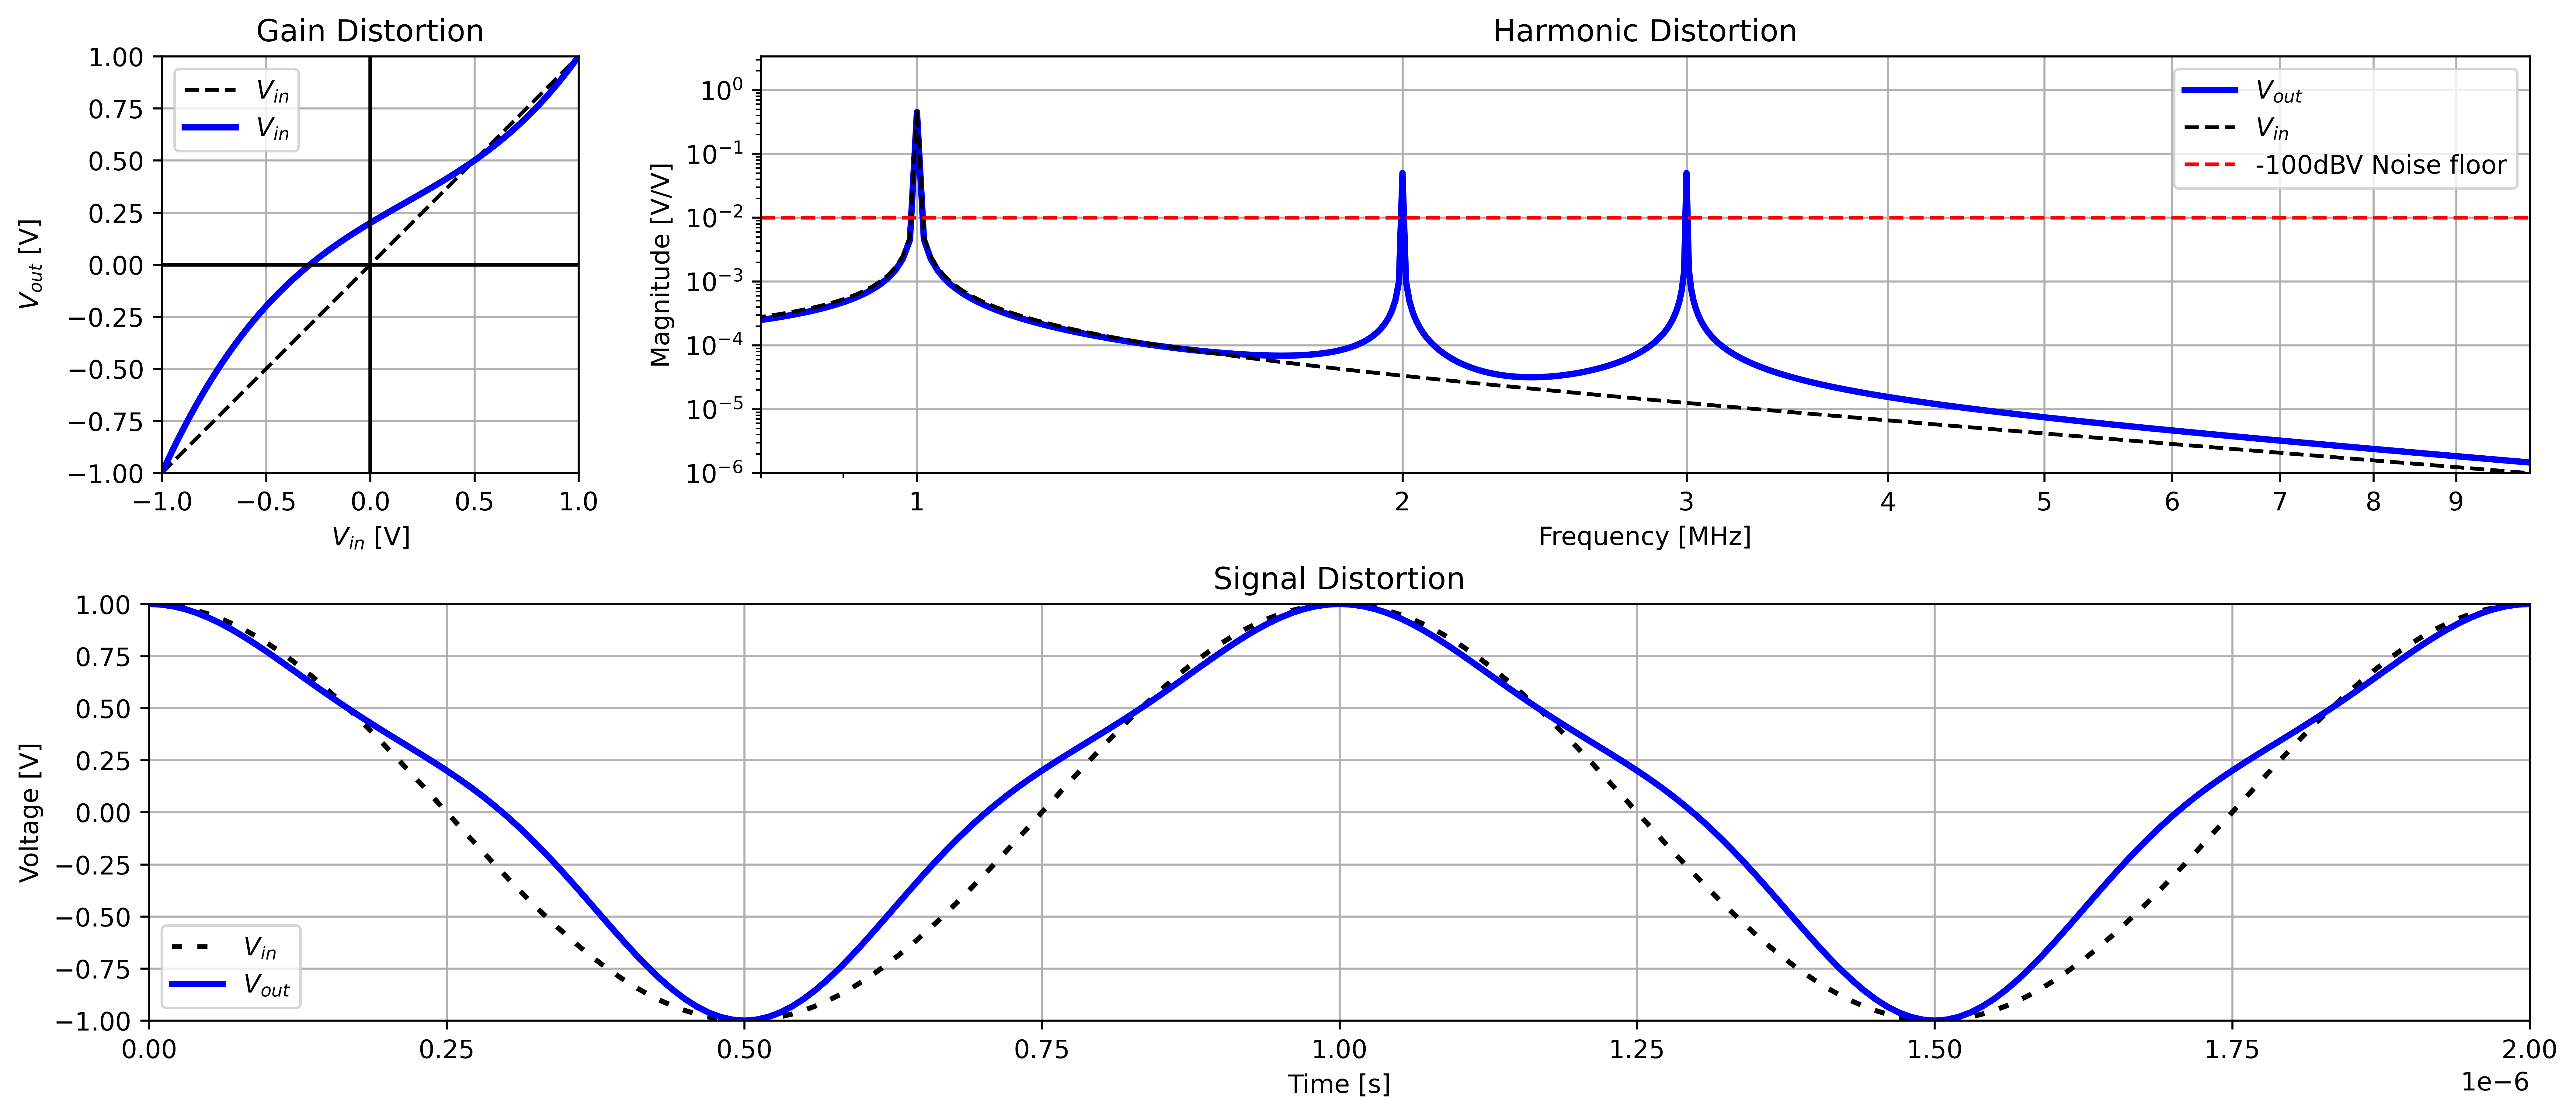

In [496]:
def plot_three_windows(t, v_in, v_out, f, f_in, f_out, sig_distortion,p_out, figsize=(14, 6), dpi=600):
    plt.clf()
    fig = plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
    #fig.tight_layout()

    gs = fig.add_gridspec(2, 2, width_ratios=[1, 4])

    ax1 = fig.add_subplot(gs[0, 0])  # top-left
    ax2 = fig.add_subplot(gs[0, 1])  # top-right
    ax3 = fig.add_subplot(gs[1, :])  # bottom full-width

    ax1.plot(np.linspace(-1,1,100), np.linspace(-1,1,100), label="$V_{in}$", color='black', linestyle="--", linewidth=1.5)
    ax1.plot(np.linspace(-1,1,100), sig_distortion, label="$V_{in}$", color='blue', linestyle="-", linewidth=2.5)

    ax1.axvline(0, color='black', linestyle="-", linewidth=1.5)
    ax1.axhline(0, color='black', linestyle="-", linewidth=1.5)

    #ax1.plot(t, v_out, label="$V_{out}$", color='blue', linestyle="-", linewidth=2.5)
    ax1.set_title("Gain Distortion")
    ax1.legend()
    ax1.set_xlabel("$V_{in}$ [V]")
    ax1.set_ylabel("$V_{out}$ [V]")
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.grid(True)
    ax1.set_aspect('equal', adjustable='box') 

    # Plotting on ax2
    ax2.plot(f/1e6, f_out, label="$V_{out}$", color='blue', linestyle="-", linewidth=2.5)
    ax2.plot(f/1e6, f_in, label="$V_{in}$", color='black', linestyle="--", linewidth=1.5)

    ax2.axhline(0.01, label="-100dBV Noise floor", color='red', linestyle="--", linewidth=1.5)

    
    ax2.set_title("Harmonic Distortion")
    ax2.legend()
    ax2.set_xlabel("Frequency [MHz]")
    ax2.set_ylabel("Magnitude [V/V]")
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(0.8, 10)
    ax2.set_ylim(1e-6, 0)
    ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax2.grid(True)

    # Plotting on ax3
    ax3.plot(t, v_in, label="$V_{in}$", color='black', linestyle=(0, (2, 3)), linewidth=2)
    ax3.plot(t, v_out, label="$V_{out}$", color='blue', linestyle="-", linewidth=2.5)
    ax3.set_title("Signal Distortion")
    ax3.legend()
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Voltage [V]")
    ax3.set_xlim(0, 2e-6)
    ax3.set_ylim(-1, 1)
    ax3.grid(True)

    fig.align_ylabels([ax1, ax3])

plot_three_windows(t, v_in, v_out, f, f_in, f_out, sig_distortion, p_out)

plt.savefig("../pictures/level-12/non-linear.pdf",transparent = True, dpi = 600)
